# Covariate Discovery Models for XGBoost & RF

The majority of this code was based off MH's education model_final. This code builds models using all variables and then generates the top 20 important features in those models. These 20 variables are then used as the initial covariates in the other modelling notebooks.

In [1]:
import pandas as pd
import numpy as np
import sys
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import pickle



In [45]:
df_broadband_tr = pd.read_csv("../../../data/current_data/train_3.csv")
test_data = pd.read_csv("../../../data/current_data/test_3.csv")

In [46]:
##drop some variables that are not numerical, highly correlated to dependent varible (bachelors degree)

to_drop = ['NAME','DDI','INFA','SE','pct_internet_none', 'pct_health_ins_19_64', 'state', 'county', 'tract_geoid',
          'pct_health_ins_children', 'tract', 'pct_health_ins_65+']
target = ['pct_health_ins_19_64']

X = df_broadband_tr.drop(to_drop, axis = 'columns', inplace=False)
y = df_broadband_tr[target]

##split into train and test 80/20 random split
from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Random Forest

### RF 1: Include all variables

In [47]:
# Fitting Random Forest Regression to the dataset

# create regressor object
rf_rg = RandomForestRegressor(n_estimators = 250, random_state = 0)

# fit the regressor with x and y data
rf_rg.fit(X_train_all, y_train_all)


<ipython-input-47-48da6e6f688e>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_rg.fit(X_train_all, y_train_all)


RandomForestRegressor(n_estimators=250, random_state=0)

In [48]:
y_pred = rf_rg.predict(X_test_all)
y_pred

array([83.294 , 87.3832, 93.0792, ..., 88.9636, 83.1488, 79.0464])

#### Feature importance

<AxesSubplot:>

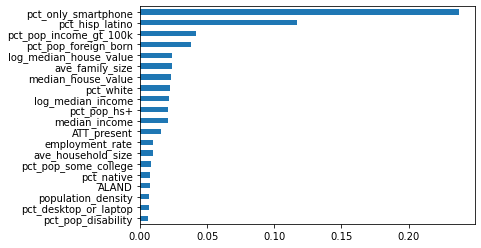

In [49]:
(pd.Series(rf_rg.feature_importances_, index=X_test_all.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh')
   )  
   

In [50]:
top_vars_rf = (pd.Series(rf_rg.feature_importances_, index=X_test_all.columns).nlargest(20)[:-1])
print(top_vars_rf)

pct_only_smartphone       0.237305
pct_hisp_latino           0.116615
pct_pop_income_gt_100k    0.041990
pct_pop_foreign_born      0.038104
log_median_house_value    0.024031
ave_family_size           0.023874
median_house_value        0.023117
pct_white                 0.022555
log_median_income         0.021409
pct_pop_hs+               0.021232
median_income             0.020665
ATT_present               0.015429
employment_rate           0.009676
ave_household_size        0.009443
pct_pop_some_college      0.008416
pct_native                0.007619
ALAND                     0.007381
population_density        0.006484
pct_desktop_or_laptop     0.006414
dtype: float64


In [51]:
top_vars_rf.index

Index(['pct_only_smartphone', 'pct_hisp_latino', 'pct_pop_income_gt_100k',
       'pct_pop_foreign_born', 'log_median_house_value', 'ave_family_size',
       'median_house_value', 'pct_white', 'log_median_income', 'pct_pop_hs+',
       'median_income', 'ATT_present', 'employment_rate', 'ave_household_size',
       'pct_pop_some_college', 'pct_native', 'ALAND', 'population_density',
       'pct_desktop_or_laptop'],
      dtype='object')

## XGBoost

In [52]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 2500)

In [53]:
## Here we will tune the below hyperparameters that are usually having a big impact on performance
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 0.3,
    'learning_rate' : 0.1,
    'alpha': 10,
    'n_estimator': 2500,
    # Other parameters
    'objective':'reg:squarederror',
}

In [ ]:
xg_reg.fit(X_train_all,y_train_all)
y_pred = xg_reg.predict(X_test_all)

#### Feature Importance

In [ ]:
(pd.Series(xg_reg.feature_importances_, index=X_test_all.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh',title="XGBOOST Feature Importance - % high school graduation", xlabel="feature")
   )  


In [ ]:
top_vars_xgb = (pd.Series(xg_reg.feature_importances_, index=X_test_all.columns).nlargest(20)[:-1])
top_vars_xgb.index